In [ ]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model

import seaborn as sns


In [ ]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


In [ ]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'emnist/balanced',
    data_dir = "/content/drive/MyDrive/Colab Notebooks/Datasets/TensorflowDatasets",
    split=['train[:80%]', 'train[80%:]', 'test'],
    
    with_info=True,
    as_supervised=True
)


In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='emnist',
    version=3.0.0,
    description='The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.',
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=47),
    }),
    total_num_examples=131600,
    splits={
        'test': 18800,
        'train': 112800,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{cohen_afshar_tapson_schaik_2017,
        title={EMNIST: Extending MNIST to handwritten lette

In [ ]:
print(type(ds_train))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


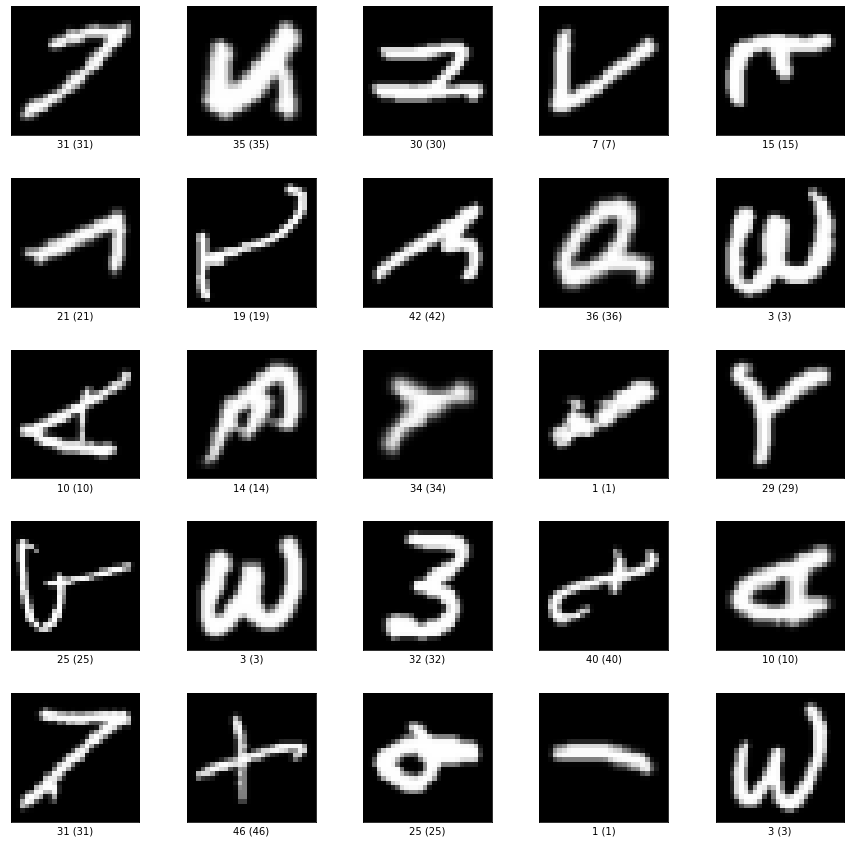

In [ ]:
fig = tfds.show_examples(ds_train, ds_info, rows = 5, cols = 5)

In [ ]:
img_height = img_width = 128

print(img_height)
print(img_width)

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64



128
128


In [ ]:
def downscale_img(image, label):
  image = tf.image.resize(image, [img_height, img_width])
  # image = tf.reshape(-1,img_height*img_width)
  return image, label



ds_train = ds_train.map(downscale_img, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(downscale_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(downscale_img, num_parallel_calls=AUTOTUNE)


In [ ]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

def configure_for_performance(ds):
    ds = ds.map(normalize_img, num_parallel_calls = AUTOTUNE)
    # ds = ds.cache("Cache")
    ds = ds.shuffle(buffer_size=256)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


def configure_for_performance_3(ds):
    ds = ds.map(normalize_img, num_parallel_calls = AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
ds_train = configure_for_performance(ds_train)
ds_val = configure_for_performance_3(ds_val)
ds_test = configure_for_performance_3(ds_test)


In [ ]:
for image, label in ds_train.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

for image, label in ds_val.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
    
for image, label in ds_test.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (64, 128, 128, 1)
Label:  [38 46  8 24 42 39 13 25 12 31  1  3 44 20 33  3 20  9 45 23 15 43 29  6
 42  1  0 14  3 24 26 24  1  2 26 23  8 16 33 14 28 26  3 40 16 33 21  5
  2 10 46 17  2 16 25  7  0  4 26 22 37  8 19 43]
Image shape:  (64, 128, 128, 1)
Label:  [ 8 37 23 18 23 29  9 23 30 39  5 35 17  9 34  7 29  4  7 35 44 22 24  0
 32  4 19 40 32 36  0  7  6 24  3 45 27 14 43 46  1 21 38  2 12 28 26  5
 34 45 43 45 20 26 16 38 16 23 11  5 42 38 26 30]
Image shape:  (64, 128, 128, 1)
Label:  [36 11 31 44 46 11  2 15 30 44 42 20 15 43 35 26 41 11 33 22 44 22 28 23
 11 33 27 16 25 42 41 17 32 31 28 24 16 46 32 32  6 10  7 22 35 29  5  1
 34 11  8 19 26 33 44 11  2  4  4 30  0 45 13 25]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

num_classes = ds_info.features["label"].num_classes

path = '/content/drive/MyDrive/Colab Notebooks/Notebooks/Models/Final/MobileNet_EMNIST_MP/'

def model_plot(model_history, p, t):


  img_path = p + t + ".png" 


  pd.DataFrame(model_history.history).plot(figsize=(16, 10))
  plt.grid(True)
  plt.gca().set_ylim(0, 1.2)
  plt.title(t)
  plt.savefig(img_path)
  plt.show()
  



In [ ]:
last_layers = 1
dropout = 1.0

n = last_layers
d = dropout
layer = 2


In [ ]:
# Creating model
base_model = tf.keras.applications.MobileNet(
    include_top=False, input_shape=(img_height, img_width, 1),
    classes=num_classes, dropout=d, weights=None)

b = -n

m = base_model.layers[b].output

m = layers.GlobalAveragePooling2D()(m)



# output layer
predictions = layers.Dense(num_classes, activation="softmax")(m)

base_model = Model(inputs = base_model.input, outputs = predictions)

base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0     

L1
L2
Epoch 1/30
1410/1410 [==============================] - 57s 37ms/step - loss: 18.1212 - accuracy: 0.1010 - val_loss: 4.3320 - val_accuracy: 0.2251
Epoch 2/30
1410/1410 [==============================] - 51s 36ms/step - loss: 3.0881 - accuracy: 0.3834 - val_loss: 2.1049 - val_accuracy: 0.6243
Epoch 3/30
1410/1410 [==============================] - 51s 36ms/step - loss: 1.8090 - accuracy: 0.6590 - val_loss: 1.4295 - val_accuracy: 0.7604
Epoch 4/30
1410/1410 [==============================] - 51s 36ms/step - loss: 1.3459 - accuracy: 0.7610 - val_loss: 1.1611 - val_accuracy: 0.8000
Epoch 5/30
1410/1410 [==============================] - 51s 36ms/step - loss: 1.1210 - accuracy: 0.8061 - val_loss: 1.0225 - val_accuracy: 0.8228
Epoch 6/30
1410/1410 [==============================] - 51s 36ms/step - loss: 0.9768 - accuracy: 0.8360 - val_loss: 0.9459 - val_accuracy: 0.8339
Epoch 7/30
1410/1410 [==============================] - 51s 36ms/step - loss: 0.8695 - accuracy: 0.8601 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Notebooks/Models/Final/MobileNet_EMNIST_MP/moled_HL_512/assets


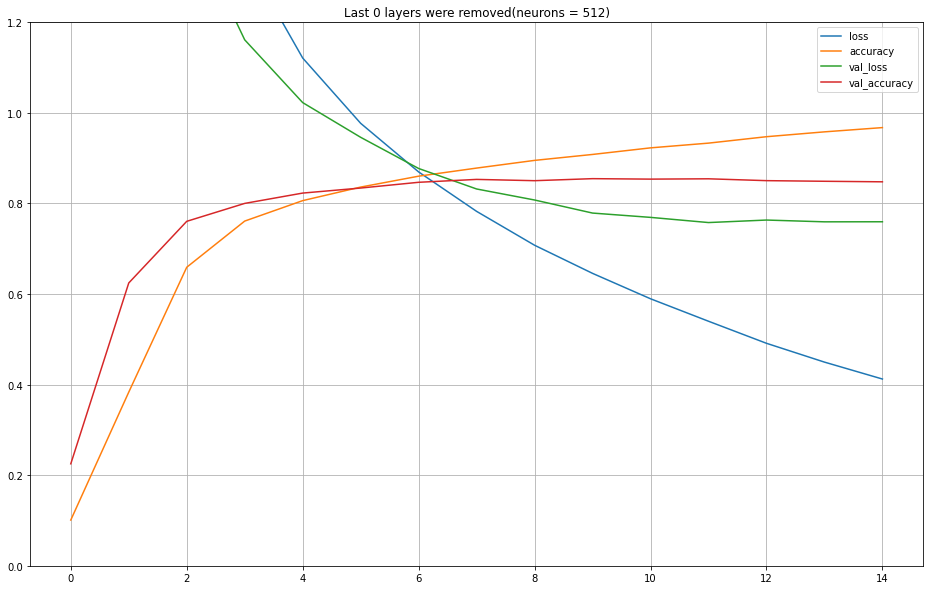

294/294 [==============================] - 5s 16ms/step - loss: 0.7964 - accuracy: 0.8526
Last 0 layers were removed
Test Accuracy: 85.255%
Loss: 0.796%





In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax


activation_funcntion = 'relu'
af = activation_funcntion
regularizer_rate = 0.05

# neurons = [256, 512]
neurons = [512]

for i in range(len(neurons)):
  
  model = base_model
  b = -2

  x = model.layers[b].output


  if layer >= 1:
    x = layers.Dense(neurons[i], activation = af,
                     kernel_regularizer=regularizers.L2(regularizer_rate)
                    )(x)
    print("L1")

    if layer >= 2:
      x = layers.Dense(neurons[i], activation = af,
                       kernel_regularizer=regularizers.L2(regularizer_rate)
                      )(x)
      x = layers.Dropout(0.2)(x)
      print("L2")
      

  predictions2 = layers.Dense(num_classes, activation="softmax")(x)

  model = Model(inputs = model.input, outputs = predictions2)

  # model.summary()


  # Model compilation
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adamax(0.0001),
                metrics=['accuracy'])


  callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience=5, restore_best_weights=True)

  # Training model
  model_history = model.fit(ds_train,
                            epochs=30,
                            validation_data=ds_val,
                            callbacks=[callback],
                            verbose=1)


  save_path = path + 'moled_HL_' + str(neurons[i])

  model.save(save_path)

  s = "Last " + str(n-1) + " layers were removed(neurons = " + str(neurons[i]) + ")"

  model_plot(model_history, path, s)

  loss_value, acc = model.evaluate(ds_test)

  print(f"Last {(n-1)} layers were removed")
  print(f"Test Accuracy: {(acc*100):.3f}%")
  print(f"Loss: {loss_value:.3f}%")
  
  print("\n\n")